In [5]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 3.1 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
#Select some pre-trained models from Hugging Face

models= [
    "facebook/bart-base",
    "allenai/longformer-base-4096",
    "google/electra-small-discriminator",
    "microsoft/mpnet-base",
    "squeezebert/squeezebert-uncased",
    "bert-base-uncased",
    "roberta-base"
]

In [12]:
#Defining parameters for text-sentence similarity

params = ["cosine_similarity", "euclidean_distance","minkowski_distance","correlation_coefficient" ,"manhattan_distance"]



In [9]:

data=[]
text1 = """
"Natural language processing (NLP) is a facet of artificial intelligence (AI) that concentrates on enhancing computer understanding and interaction with humans using language. The primary aim of NLP is to empower computers to comprehend, interpret, and generate human language in ways that are meaningful and contextually relevant."""

text2="""
In the field of artificial intelligence, machine learning serves as a crucial subset involving the creation of algorithms and statistical models, enabling computers to execute specific tasks without explicit programming. In the context of natural language processing, machine learning algorithms play a pivotal role in analyzing and deciphering the structure and meaning embedded in human language."""

In [14]:
for model_name in models:
    model = SentenceTransformer(model_name)

    cosine_sim = cosine_similarity(model.encode([text1]), model.encode([text2]))[0][0]
    euclidean_dist = np.linalg.norm(model.encode([text1]) - model.encode([text2]))
    manhattan_dist = np.abs(model.encode([text1]) - model.encode([text2])).sum()
    minkowski_dist = np.power(np.power(np.abs(model.encode([text1]) - model.encode([text2])), 3).sum(), 1/3)
    correlation_coeff = np.corrcoef(model.encode([text1])[0], model.encode([text2])[0])[0, 1]

    param_values = [cosine_sim, euclidean_dist, manhattan_dist, minkowski_dist, correlation_coeff]

    data.append([model_name] + param_values)

Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
cols = ["Model"] + params
df = pd.DataFrame(data, columns=cols)

#Normalizing the parameter values

normalized_df=df.copy()
for p in params:
   normalized_df[p] = (df[p] - df[p].min()) / (df[p].max() - df[p].min())

#Assuming equal criteria weights

weights = [1] * len(params)

#Multiply normalized parameter values with criteria weights
weighted_normalized_matrix = normalized_df.iloc[:, 1:] * weights

#Calculation of positive and negative ideal solutions

positive_ideal_solution = weighted_normalized_matrix.max(axis=0)
negative_ideal_solution = weighted_normalized_matrix.min(axis=0)

#Calculating the distance of each model from positive and negative ideal solutions

distance_positive_ideal = np.linalg.norm(weighted_normalized_matrix - positive_ideal_solution, axis=1)
distance_negative_ideal = np.linalg.norm(weighted_normalized_matrix - negative_ideal_solution, axis=1)

#Calculating TOPSIS score

normalized_df["Topsis_Score"] = normalized_df.apply(lambda row: np.sqrt(np.sum((row - positive_ideal_solution) ** 2)), axis=1)

#Rank models on the basis of topsis score

df_Ranked = normalized_df.sort_values(by="Topsis_Score", ascending=False).reset_index(drop=True)

df_Ranked


,Model,cosine_similarity,euclidean_distance,minkowski_distance,correlation_coefficient,manhattan_distance,Topsis_Score
0,squeezebert/squeezebert-uncased,0.000000,0.012622,0.027437,0.000000,0.000000,2.218286
1,squeezebert/squeezebert-uncased,0.000000,0.012622,0.027437,0.000000,0.000000,2.218286
2,microsoft/mpnet-base,0.909806,0.000000,0.000000,0.019485,0.908176,1.725681
3,microsoft/mpnet-base,0.909806,0.000000,0.000000,0.019485,0.908176,1.725681
4,google/electra-small-discriminator,0.555548,0.100053,0.042628,0.112641,0.546871,1.707845
5,google/electra-small-discriminator,0.555548,0.100053,0.042628,0.112641,0.546871,1.707845
6,bert-base-uncased,0.254478,0.237983,0.264908,0.196375,0.253182,1.697169
7,bert-base-uncased,0.254478,0.237983,0.264908,0.196375,0.253182,1.697169
8,roberta-base,1.000000,0.053090,0.060764,0.044054,1.000000,1.640925
9,roberta-base,1.000000,0.053090,0.060764,0.044054,1.000000,1.640925


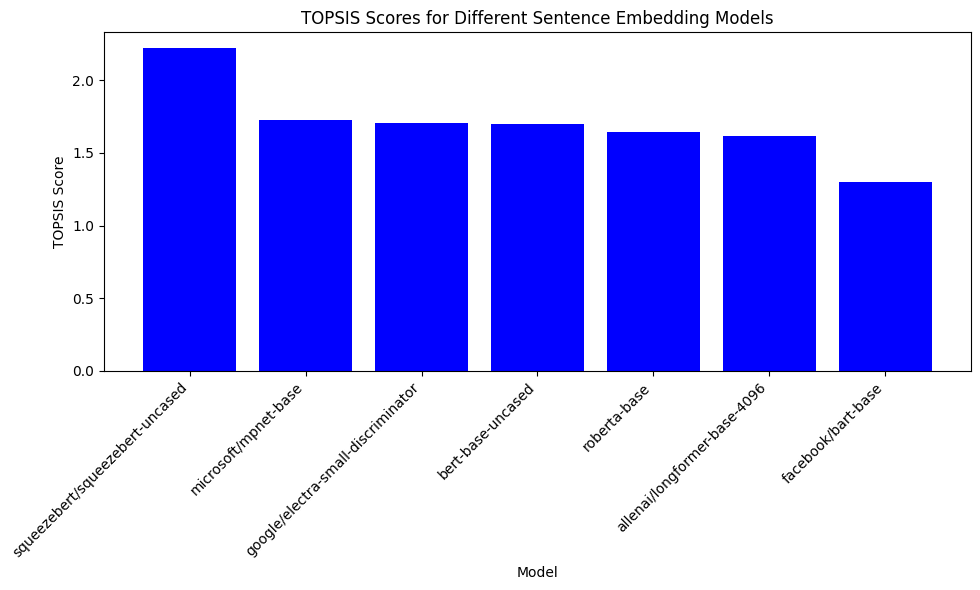

In [24]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.bar(df_Ranked['Model'], df_Ranked['Topsis_Score'], color='blue')
plt.xlabel('Model')
plt.ylabel('TOPSIS Score')
plt.title('TOPSIS Scores for Different Sentence Embedding Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
